# Import the packages and check connection to bucket

In [1]:
from google.cloud import storage
import pandas as pd ## for dataset and eda
import numpy as np ## for eda
from datetime import datetime

In [2]:
bucket_name = "firstprojectdl"

storage_client = storage.Client()
bucket = storage_client.get_bucket(bucket_name)

print(bucket)
print('Great, we now have access to our first bucket on google cloud storage where we put our data')

<Bucket: firstprojectdl>
Great, we now have access to our first bucket on google cloud storage where we put our data


# Read the datasets from google cloud storage

In [3]:
from google.cloud import storage
import pandas as pd

bucket_name = "firstprojectdl"

storage_client = storage.Client()
bucket = storage_client.get_bucket(bucket_name)

# When you have your files in a subfolder of the bucket.
my_prefix = "data/movieLens/movieLens100k/" # the name of the subfolder
blobs = bucket.list_blobs(prefix = my_prefix, delimiter = '/')

dfDict = {}
dateparse = lambda x: datetime.utcfromtimestamp(int(x)).strftime('%Y-%m-%d %H:%M:%S')

for blob in blobs:
    if(blob.name != my_prefix): # ignoring the subfolder itself 
        file_name = blob.name.replace(my_prefix, "")
        blob.download_to_filename(file_name) # download the file to the machine
        print(file_name)
        if file_name =='u.data':
            df = pd.read_csv(file_name, sep='\t', 
                            names=['user_id', 'movie_id', 'rating', 'timestamp'], 
                            parse_dates=['timestamp'], 
                            date_parser=dateparse) # load the rating data
        elif file_name == 'u.item':
            df = pd.read_csv('u.item', sep='|', encoding='latin-1',
                    names=['movie_id', 'movie_title', 'release_date', 'video_release_date', 'imdb_url', 'unknown', 'action', 
                           'adventure', 'animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 
                           'film_noir', 'horror', 'musical', 'mystery', 'romance', 'sci_fi', 'thriller', 'war', 'western']) # load the movie data
        elif file_name == 'u.user':
            df = pd.read_csv('u.user', sep='|', encoding='latin-1',
                     names=['user_id', 'age', 'gender', 'occupation', 'zip_code']) # user_df
        dfDict[file_name] = df
        



dfDict['rating'] = dfDict['u.data'] 
del dfDict['u.data'] 
        
dfDict['movie'] = dfDict['u.item'] 
del dfDict['u.item'] 

dfDict['user'] = dfDict['u.user'] 
del dfDict['u.user'] 

## This is the list of datasets we have for the movieLens 100k!!
print(list(dfDict))

u.data
u.item
u.user
['rating', 'movie', 'user']


In [4]:
df = dfDict['rating'] ## our rating dataset
df.head()

,user_id,movie_id,rating,timestamp
0,196,242,3,1997-12-04 15:55:49
1,186,302,3,1998-04-04 19:22:22
2,22,377,1,1997-11-07 07:18:36
3,244,51,2,1997-11-27 05:02:03
4,166,346,1,1998-02-02 05:33:16


In [5]:
n_users = df.user_id.unique().shape[0]
print(f'Number of users: {n_users}')
n_items = df.movie_id.unique().shape[0]
print(f'Number of items/movies rated: {n_items}')


Number of users: 943
Number of items/movies rated: 1682


In [6]:
## then create the rating matrix with dimension (number of users, number of items)

ratings = np.zeros((n_users, n_items))
print(ratings)
print(f'Matrix shape is {ratings.shape}')
maxRatingsPossible = n_users * n_items
print(f'Maximum number of ratings is {maxRatingsPossible}. With this number of ratings, the matrix would be dense')

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Matrix shape is (943, 1682)
Maximum number of ratings is 1586126. With this number of ratings, the matrix would be dense


Fill the matrix with the ratings submitted by each of the users!!

In [7]:
## what we do here here is as follows:
# 1. we iterate over the dataframe rows
# 2. we then go to the right user id row
# and rating column and then assign it the right rating
for row in df.itertuples():
    ratings[row[1]-1, row[2]-1] = row[3] 
ratings

array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

Calculate the matrix sparsity

In [8]:
numerator = float(len(ratings.nonzero()[0])) # of course, we have 100,000 ratings
denominator =(ratings.shape[0] * ratings.shape[1]) # then 100000/1586126 

sparsity = numerator/denominator

sparsity *= 100 # get the percentage

print(f'Matrix Sparsity : {round(sparsity, 3)} %')

Matrix Sparsity : 6.305 %


# Split the datasets in train, validation, test

In [9]:
def train_val_test_split(ratings):
    """
    The purpose of this method is split our datasets betwen:
    1. Train
    2. Validation (we extracted 7 ratings for a user from train and put it in there)
    3. Test (we extracted 7 ratings for a user from train and put it in there)
    We go through each of the user and randonly select ratings from train set that will go
    from the initial matrix, take 7 to put in the validation matrix 
    and take 7 to put in the test matrix. Finally these ratings that have been put in 
    the test and val sets are set to 0 in the main/train matrix
    """
    test = np.zeros(ratings.shape)
    validation = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                       size=7, 
                                        replace=False) # for user, get the test rating array
        val_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                       size=7, 
                                        replace=False) # for user, get the validation array
        train[user, test_ratings] = 0. # set to 0 the train matrix/copy of the original matrix the ratings taken for test
        train[user, val_ratings] = 0.# set to 0 the train matrix/copy of the original matrix the ratings taken for validation
        test[user, test_ratings] = ratings[user, test_ratings] # assign to the test matrix/matrix of 0 the test ratings
        validation[user, val_ratings] = ratings[user, val_ratings] # assign to the val matrix/matrix of 0 the val ratings
        
    assert(np.all((train * test * validation) == 0))

    return train, validation, test

In [10]:
train, validation, test = train_val_test_split(ratings)

print("This is the train rating matrix")
print(train) 
print(f"The shape is {train.shape}")
print("This is the validation rating matrix")
print(validation)
print(f"The shape is {validation.shape}")
print("This is the test rating matrix")
print(test)
print(f"The shape is {test.shape}")

This is the train rating matrix
[[5. 3. 4. ... 0. 0. 0.]
 [4. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 5. 0. ... 0. 0. 0.]]
The shape is (943, 1682)
This is the validation rating matrix
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [5. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
The shape is (943, 1682)
This is the test rating matrix
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
The shape is (943, 1682)


## MF Implementation with Alternating Least Squares (ALS) 

With a training, validation and test set, we can now move towards a Traditional MF based recommendation system.

What are the assumptions of Matrix Factorization?

- It assumes that each user can be described by k attributes. For instance, feature number 1 might correspond to how much a user likes sci movies..

- It also assumes that movies can be described by k features as well! but for movies!
In this case, feature number might correspond to how much a movie is close to the characteristics of a sci movie

- Finally, it multiplies each feature of the user by the features of the mobies and dot product --> voila --> This would FINALLY BE A GOOD APPROXIMATION FOR THE RATING THE USER WOULD GIVE THAT MOVIE!

You may ask how we know these features and whether they are relevant? We learn them by tweaking the number of k parameters and learn the relevant values for the user and item. These features are learnt by minimizing a loss function

- What is the math behind?

Quite straightforward!

It is the dot product of the following k dimensional vectors:
1. Vector for the user u with vector x_u of k dimensional vector
2. Vector for the item (movie) i with vecotr yi


rating(ui - predicted) = (Xu.Transpose * Yi)


The user and item vectors are the low dimensional embeddings. And the k embeddings are the latent factors.
The Loss function we will minimize is a MSE with 2 regularization terms on the user and items vectors to prevent overfitting.

We ll minimize it with derivative based methods such as ALS and then SGD

In [11]:
from numpy.linalg import solve

Let us implement the Matrix Factorization code that executes the Matrix Factorization with the Alternating Square Methods

How does the ALS (Alternating Least Squares) work for training the model?

For each round of ALS, whether on user or item, we hold the other latent vector constant. 

Example:
0. Remember that the goal is to generate latent vectors m by k so first we randonly generate numpy arrays of m by k with values inside for both the user and the movie vector
1. To continue in our derivation we need to keep one of the latent vectors constant. For this first round, we keep the item (movie) vector constant.
2. Then we take the derivative of the loss function with respect to the other set of vectors, that is in this case the user vectors.
3. We then solve for the derivative equal to 0
4. We solve for the non constant vectors (user vectors)
5. Once the solved vectors (for users) are obtained, JUST DO THE ALTERNATING DANCE!
6. Hold the user latent vector constant this time and now make the item latent vector the non constant --> Take the derivative of the loss function with respect to the previously constant vectors (the item vectors).
7. We do this alternating dance and do 1 through 6 until convergence




In [12]:
class MFals():
    def __init__(self, 
                 ratings, 
                 n_factors=40, 
                 item_reg=0.0, 
                 user_reg=0.0,
                 verbose=False
                ):
        """
        Train a matrix factorization model to predict empty 
        entries in a matrix. The terminology assumes a 
        ratings matrix which is ~ user x item
        
        Params
        ======
        ratings : (ndarray)
            User x Item matrix with corresponding ratings
        
        n_factors : (int)
            Number of latent factors to use in matrix 
            factorization model
        
        item_reg : (float)
            Regularization term for item latent factors
        
        user_reg : (float)
            Regularization term for user latent factors
        
        verbose : (bool)
            Whether or not to printout training progress
        """
        
        self.ratings = ratings
        self.n_users, self.n_items = ratings.shape
        self.n_factors = n_factors ## our k number of attributes!!
        self.item_reg = item_reg
        self.user_reg = user_reg
        self._v = verbose

    def als_step(self,
                 latent_vectors,
                 fixed_vecs,
                 ratings,
                 _lambda,
                 type='user'):
        """
        One of the two ALS steps. Solve for the latent vectors
        specified by type.
        """
        if type == 'user':
            # Precompute
            YTY = fixed_vecs.T.dot(fixed_vecs) # the Y times Y transpose part of the derived function equal to 0
            lambdaI = np.eye(YTY.shape[0]) * _lambda # the second argument to get the user latent vectors

            for u in range(latent_vectors.shape[0]):
                latent_vectors[u, :] = solve((YTY + lambdaI), 
                                             ratings[u, :].dot(fixed_vecs)) ## here what we do is search for the latent vectors for each of the user u
        elif type == 'item':
            # Precompute
            XTX = fixed_vecs.T.dot(fixed_vecs) # same calculation as above but with user vector
            lambdaI = np.eye(XTX.shape[0]) * _lambda
            
            for i in range(latent_vectors.shape[0]):
                latent_vectors[i, :] = solve((XTX + lambdaI), 
                                             ratings[:, i].T.dot(fixed_vecs)) ## here what we do is search for the latent vectors for each of the movie i in the column!
        return latent_vectors

    def train(self, n_iter=10):
        """ Train model for n_iter iterations from scratch."""
        # initialize latent vectors
        self.user_vecs = np.random.random((self.n_users, self.n_factors)) # random start for our user vecs and item vecs before we improve them with the ALS
        self.item_vecs = np.random.random((self.n_items, self.n_factors))
        
        self.partial_train(n_iter)
    
    def partial_train(self, n_iter):
        """ 
        Train model for n_iter iterations. Can be 
        called multiple times for further training.
        Get the user_vecs and item_vecs latent vectors
        """
        ctr = 1
        while ctr <= n_iter:
            if ctr % 10 == 0 and self._v:
                print(f'current iteration: {ctr}')
            self.user_vecs = self.als_step(self.user_vecs, 
                                           self.item_vecs, 
                                           self.ratings, 
                                           self.user_reg, 
                                           type='user') # our user latent vector
            self.item_vecs = self.als_step(self.item_vecs, 
                                           self.user_vecs, 
                                           self.ratings, 
                                           self.item_reg, 
                                           type='item') # our item latent vactor
            ctr += 1
    
    def predict_all(self):
        """ Predict ratings for every user and item. """
        predictions = np.zeros((self.user_vecs.shape[0], 
                                self.item_vecs.shape[0]))
        for u in range(self.user_vecs.shape[0]):
            for i in range(self.item_vecs.shape[0]):
                predictions[u, i] = self.predict(u, i)
                
        return predictions
    def predict(self, u, i):
        """ Single user and item prediction. """
        return self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
    
    def calculate_learning_curve(self, iter_array, val, training=True):
        """
        Keep track of RMSE as a function of training iterations.
        
        Params
        ======
        iter_array : (list)
            List of numbers of iterations to train for each step of 
            the learning curve. e.g. [1, 5, 10, 20]
        val : (2D ndarray)
            Validation dataset (assumed to be user x item).
        
        The function creates two new class attributes:
        
        train_rmse : (list)
            Training data RMSE values for each value of iter_array
        val_rmse : (list)
            val data RMSE values for each value of iter_array
        """
        
        if training:
            iter_array.sort()
            self.train_rmse =[]
            self.val_rmse = []
            iter_diff = 0
            for (i, n_iter) in enumerate(iter_array):
                if self._v:
                    print('Iteration: {n_iter}')
                if i == 0:
                    self.train(n_iter - iter_diff)
                else:
                    self.partial_train(n_iter - iter_diff)

                predictions = self.predict_all()

                self.train_rmse += [get_rmse(predictions, self.ratings)]
                self.val_rmse += [get_rmse(predictions, val)]
                if self._v:
                    print('Train rmse: ' + str(self.train_rmse[-1]))
                    print('Validation rmse: ' + str(self.val_rmse[-1]))
                iter_diff = n_iter
                
        if training == False:
            iter_array.sort()
            self.test_rmse = []
            iter_diff = 0
            for (i, n_iter) in enumerate(iter_array):
            
                predictions = self.predict_all()

                self.test_rmse += [get_rmse(predictions, val)]

                iter_diff = n_iter
            

The function to get the RMSE

In [13]:
from sklearn.metrics import mean_squared_error

def get_rmse(pred, actual):
    """ The goal of this function is to get the RMSE 
    to assess the performance of the learner
    """
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual, squared=False)

Let us assess training versus validation

In [14]:
%%time
MF_als = MFals(train, n_factors=40, user_reg=0.0, item_reg=0.0)
iter_array = [1, 2, 5, 10, 25, 50, 100]
MF_als.calculate_learning_curve(iter_array, validation)

CPU times: user 36.4 s, sys: 49.2 ms, total: 36.4 s
Wall time: 25.2 s


In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

def plot_learning_curve(iter_array, model):
    plt.plot(iter_array, model.train_rmse, \
             label='Training', linewidth=5)
    plt.plot(iter_array, model.val_rmse, \
             label='Validation', linewidth=5)


    plt.xticks(fontsize=16);
    plt.yticks(fontsize=16);
    plt.xlabel('iterations', fontsize=30);
    plt.ylabel('RMSE', fontsize=30);
    plt.legend(loc='best', fontsize=20);

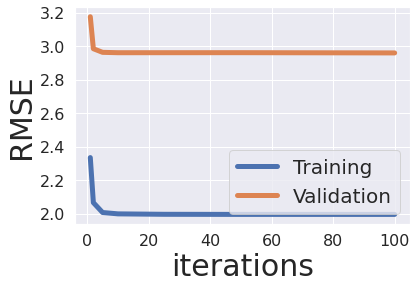

In [16]:
plot_learning_curve(iter_array, MF_als)

Let us assess validation versus testing

In [17]:
%%time
MF_als.calculate_learning_curve(iter_array, test, training=False)

CPU times: user 15.4 s, sys: 4.12 ms, total: 15.4 s
Wall time: 15.4 s


In [40]:
def plot_learning_curveTest(iter_array, model):
    plt.plot(iter_array, model.val_rmse, \
             label='Validation', linewidth=5)
    plt.plot(iter_array, model.test_rmse, \
             label='Test', linewidth=5)


    plt.xticks(fontsize=16);
    plt.yticks(fontsize=16);
    plt.xlabel('iterations', fontsize=30);
    plt.ylabel('RMSE', fontsize=30);
    plt.legend(loc='best', fontsize=20);

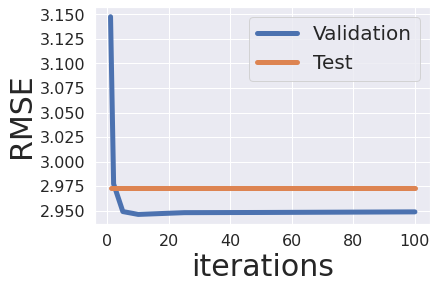

In [41]:
plot_learning_curveTest(iter_array, MF_als)

Optimizing the ALS model parameters

While comparing the validation and training sets, we can say that the amount of overfitting is reasonable

And the performance bottoms out at around 5 to 10 iterations too

Let us increase the regularization term in the MF

In [42]:
%%time
MF_alsOpt = MFals(train, n_factors=40, \
                    user_reg=30., item_reg=30.)

iter_array = [1, 2, 5, 10, 25, 50, 100]
MF_alsOpt.calculate_learning_curve(iter_array, validation)

CPU times: user 36.3 s, sys: 51.8 ms, total: 36.4 s
Wall time: 25.4 s


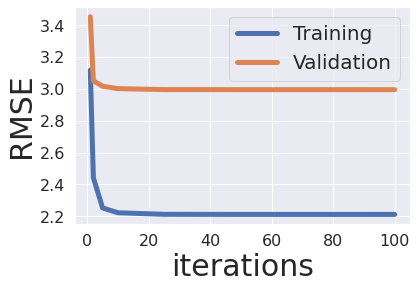

In [43]:
plot_learning_curve(iter_array, MF_alsOpt)

Increasing the RMSE did not change the performance much

Using a greater RMSE did not help improve performance on validation set and then decrease the gap between the training and validation

We will optimize performance by fine tuning the regularization term and the number k of latent factors. 

The item and user regularization terms will be restricted to be equal to each other.

# Fine Tune the MF Hyperparameters (ALS) to minimize loss function

In [44]:
from tqdm import tqdm

In [45]:
%%time
latent_factors = [5, 10, 20, 40, 80]
regularizations = [0.1, 1., 10., 100.]
regularizations.sort()
iter_array = [1, 2, 5, 10, 25, 50, 100]

best_params = {}
best_params['n_factors'] = latent_factors[0]
best_params['reg'] = regularizations[0]
best_params['n_iter'] = 0
best_params['train_mse'] = np.inf
best_params['test_mse'] = np.inf
best_params['model'] = None

for fact in tqdm(latent_factors):
    print(f'Factors: {fact}')
    for reg in regularizations:
        print(f'Regularization: {reg}')
        MF_alsFineTuned = MFals(train, n_factors=fact, \
                            user_reg=reg, item_reg=reg)
        MF_alsFineTuned.calculate_learning_curve(iter_array, validation)
        min_idx = np.argmin(MF_alsFineTuned.val_rmse)
        if MF_alsFineTuned.val_rmse[min_idx] < best_params['test_mse']:
            best_params['n_factors'] = fact
            best_params['reg'] = reg
            best_params['n_iter'] = iter_array[min_idx]
            best_params['train_rmse'] = MF_alsFineTuned.train_rmse[min_idx]
            best_params['val_rmse'] = MF_alsFineTuned.val_rmse[min_idx]
            best_params['model'] = MF_alsFineTuned
            print('New optimal hyperparameters')
            print(pd.Series(best_params))

  0%|          | 0/5 [00:00<?, ?it/s]

Factors: 5
Regularization: 0.1
New optimal hyperparameters
n_factors                                             5
reg                                                 0.1
n_iter                                                5
train_mse                                           inf
test_mse                                            inf
model         <__main__.MFals object at 0x7f529ae433d0>
train_rmse                                     2.488258
val_rmse                                       2.993085
dtype: object
Regularization: 1.0
New optimal hyperparameters
n_factors                                             5
reg                                                 1.0
n_iter                                               25
train_mse                                           inf
test_mse                                            inf
model         <__main__.MFals object at 0x7f529aff1350>
train_rmse                                     2.495253
val_rmse                               

 20%|██        | 1/5 [01:29<05:56, 89.24s/it]

New optimal hyperparameters
n_factors                                             5
reg                                               100.0
n_iter                                               10
train_mse                                           inf
test_mse                                            inf
model         <__main__.MFals object at 0x7f529aff10d0>
train_rmse                                     2.760154
val_rmse                                       3.212161
dtype: object
Factors: 10
Regularization: 0.1
New optimal hyperparameters
n_factors                                            10
reg                                                 0.1
n_iter                                              100
train_mse                                           inf
test_mse                                            inf
model         <__main__.MFals object at 0x7f529aff1250>
train_rmse                                     2.337867
val_rmse                                       2.902607
dt

 40%|████      | 2/5 [03:00<04:31, 90.50s/it]

New optimal hyperparameters
n_factors                                            10
reg                                               100.0
n_iter                                               50
train_mse                                           inf
test_mse                                            inf
model         <__main__.MFals object at 0x7f529aff1190>
train_rmse                                     2.738408
val_rmse                                       3.193542
dtype: object
Factors: 20
Regularization: 0.1
New optimal hyperparameters
n_factors                                            20
reg                                                 0.1
n_iter                                              100
train_mse                                           inf
test_mse                                            inf
model         <__main__.MFals object at 0x7f529aff1490>
train_rmse                                     2.196804
val_rmse                                       2.883696
dt

 60%|██████    | 3/5 [04:31<03:01, 90.76s/it]

New optimal hyperparameters
n_factors                                            20
reg                                               100.0
n_iter                                               50
train_mse                                           inf
test_mse                                            inf
model         <__main__.MFals object at 0x7f529aff1650>
train_rmse                                     2.738408
val_rmse                                       3.193542
dtype: object
Factors: 40
Regularization: 0.1
New optimal hyperparameters
n_factors                                            40
reg                                                 0.1
n_iter                                              100
train_mse                                           inf
test_mse                                            inf
model         <__main__.MFals object at 0x7f529aff15d0>
train_rmse                                     1.996241
val_rmse                                       2.949918
dt

 80%|████████  | 4/5 [06:13<01:35, 95.19s/it]

New optimal hyperparameters
n_factors                                            40
reg                                               100.0
n_iter                                               25
train_mse                                           inf
test_mse                                            inf
model         <__main__.MFals object at 0x7f529aff1610>
train_rmse                                     2.738407
val_rmse                                       3.193542
dtype: object
Factors: 80
Regularization: 0.1
New optimal hyperparameters
n_factors                                            80
reg                                                 0.1
n_iter                                                2
train_mse                                           inf
test_mse                                            inf
model         <__main__.MFals object at 0x7f529aff1190>
train_rmse                                     1.772862
val_rmse                                       3.096159
dt

100%|██████████| 5/5 [08:50<00:00, 106.10s/it]

New optimal hyperparameters
n_factors                                            80
reg                                               100.0
n_iter                                               25
train_mse                                           inf
test_mse                                            inf
model         <__main__.MFals object at 0x7f529aff1290>
train_rmse                                     2.738402
val_rmse                                       3.193539
dtype: object
CPU times: user 12min 43s, sys: 1.76 s, total: 12min 44s
Wall time: 8min 50s


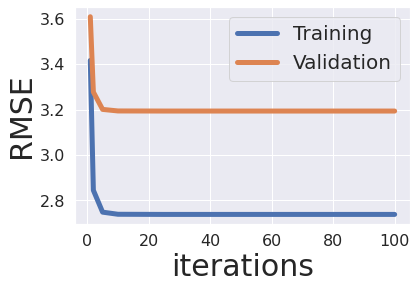

In [47]:
plot_learning_curve(iter_array, best_params['model'])


In [48]:
print(f'Best regularization: {best_params["reg"]}')
print(f'Best latent factors: {best_params["n_factors"]}')
print(f'Best iterations: {best_params["n_iter"]}')

Best regularization: 100.0
Best latent factors: 80
Best iterations: 25


We can see that the best validation RMSE is at around 2.95 and that only the iteration count reached its maximum to a 100. To further fine tune the  grid searc, we could have increased to a wider range.

The best performing parameters are 10 factors and a reg ter of 0.1 on both users and items

## MF Implementation with Stochastic Gradient Descent (SGD) 

With SGD, we again take derivatives of the loss function, but we take the derivative with respect to each variable in the model


How do we derive the loss function?

We will use a similar loss function to before, but with some more details to the model. Instead of assuming that a user u’s rating for item i can be described simply by the dot product of the user and item latent vectors, we will consider that each user and item can have a bias term associated with them.


We are going to implement MF with sgd derivation added this time!

In [19]:
class MF():
    def __init__(self, 
                 ratings,
                 n_factors=40,
                 learning='sgd',
                 item_fact_reg=0.0, 
                 user_fact_reg=0.0,
                 item_bias_reg=0.0,
                 user_bias_reg=0.0,
                 verbose=False):
        """
        Train a matrix factorization model to predict empty 
        entries in a matrix. The terminology assumes a 
        ratings matrix which is ~ user x item
        
        Params
        ======
        ratings : (ndarray)
            User x Item matrix with corresponding ratings
        
        n_factors : (int)
            Number of latent factors to use in matrix 
            factorization model
        learning : (str)
            Method of optimization. Options include 
            'sgd' or 'als'.
        
        item_fact_reg : (float)
            Regularization term for item latent factors
        
        user_fact_reg : (float)
            Regularization term for user latent factors
            
        item_bias_reg : (float)
            Regularization term for item biases
        
        user_bias_reg : (float)
            Regularization term for user biases
        
        verbose : (bool)
            Whether or not to printout training progress
        """
        
        self.ratings = ratings
        self.n_users, self.n_items = ratings.shape
        self.n_factors = n_factors
        self.item_fact_reg = item_fact_reg
        self.user_fact_reg = user_fact_reg
        self.item_bias_reg = item_bias_reg
        self.user_bias_reg = user_bias_reg
        self.learning = learning
        if self.learning == 'sgd':
            self.sample_row, self.sample_col = self.ratings.nonzero()
            self.n_samples = len(self.sample_row)
        self._v = verbose

    def als_step(self,
                 latent_vectors,
                 fixed_vecs,
                 ratings,
                 _lambda,
                 type='user'):
        """
        One of the two ALS steps. Solve for the latent vectors
        specified by type.
        """
        if type == 'user':
            # Precompute
            YTY = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(YTY.shape[0]) * _lambda

            for u in range(latent_vectors.shape[0]):
                latent_vectors[u, :] = solve((YTY + lambdaI), 
                                             ratings[u, :].dot(fixed_vecs))
        elif type == 'item':
            # Precompute
            XTX = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(XTX.shape[0]) * _lambda
            
            for i in range(latent_vectors.shape[0]):
                latent_vectors[i, :] = solve((XTX + lambdaI), 
                                             ratings[:, i].T.dot(fixed_vecs))
        return latent_vectors

    def train(self, n_iter=10, learning_rate=0.1):
        """ Train model for n_iter iterations from scratch."""
        # initialize latent vectors        
        self.user_vecs = np.random.normal(scale=1./self.n_factors,\
                                          size=(self.n_users, self.n_factors))
        self.item_vecs = np.random.normal(scale=1./self.n_factors,
                                          size=(self.n_items, self.n_factors))
        
        if self.learning == 'als':
            self.partial_train(n_iter)
        elif self.learning == 'sgd':
            self.learning_rate = learning_rate
            self.user_bias = np.zeros(self.n_users)
            self.item_bias = np.zeros(self.n_items)
            self.global_bias = np.mean(self.ratings[np.where(self.ratings != 0)])
            self.partial_train(n_iter)
    
    
    def partial_train(self, n_iter):
        """ 
        Train model for n_iter iterations. Can be 
        called multiple times for further training.
        """
        ctr = 1
        while ctr <= n_iter:
            if ctr % 10 == 0 and self._v:
                print(f'\tcurrent iteration: {ctr}')
            if self.learning == 'als':
                self.user_vecs = self.als_step(self.user_vecs, 
                                               self.item_vecs, 
                                               self.ratings, 
                                               self.user_fact_reg, 
                                               type='user')
                self.item_vecs = self.als_step(self.item_vecs, 
                                               self.user_vecs, 
                                               self.ratings, 
                                               self.item_fact_reg, 
                                               type='item')
            elif self.learning == 'sgd':
                self.training_indices = np.arange(self.n_samples)
                np.random.shuffle(self.training_indices)
                self.sgd()
            ctr += 1

    def sgd(self):
        for idx in self.training_indices:
            u = self.sample_row[idx]
            i = self.sample_col[idx]
            prediction = self.predict(u, i)
            e = (self.ratings[u,i] - prediction) # error
            
            # Update biases
            self.user_bias[u] += self.learning_rate * \
                                (e - self.user_bias_reg * self.user_bias[u])
            self.item_bias[i] += self.learning_rate * \
                                (e - self.item_bias_reg * self.item_bias[i])
            
            #Update latent factors
            self.user_vecs[u, :] += self.learning_rate * \
                                    (e * self.item_vecs[i, :] - \
                                     self.user_fact_reg * self.user_vecs[u,:])
            self.item_vecs[i, :] += self.learning_rate * \
                                    (e * self.user_vecs[u, :] - \
                                     self.item_fact_reg * self.item_vecs[i,:])
    def predict(self, u, i):
        """ Single user and item prediction."""
        if self.learning == 'als':
            return self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
        elif self.learning == 'sgd':
            prediction = self.global_bias + self.user_bias[u] + self.item_bias[i]
            prediction += self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
            return prediction
    
    def predict_all(self):
        """ Predict ratings for every user and item."""
        predictions = np.zeros((self.user_vecs.shape[0], 
                                self.item_vecs.shape[0]))
        for u in range(self.user_vecs.shape[0]):
            for i in range(self.item_vecs.shape[0]):
                predictions[u, i] = self.predict(u, i)
                
        return predictions
    
    def calculate_learning_curve(self, iter_array, val, learning_rate=0.1, training=True):
        """
        Keep track of RMSE as a function of training iterations.
        
        Params
        ======
        iter_array : (list)
            List of numbers of iterations to train for each step of 
            the learning curve. e.g. [1, 5, 10, 20]
        test : (2D ndarray)
            Testing dataset (assumed to be user x item).
        
        The function creates two new class attributes:
        
        train_rmse : (list)
            Training data MSE values for each value of iter_array
        val_rmse : (list)
            Test data MSE values for each value of iter_array
        """
        if training:
            iter_array.sort()
            self.train_rmse =[]
            self.val_rmse = []
            iter_diff = 0
            for (i, n_iter) in enumerate(iter_array):
                if self._v:
                    print(f'Iteration: {n_iter}')
                if i == 0:
                    self.train(n_iter - iter_diff, learning_rate)
                else:
                    self.partial_train(n_iter - iter_diff)

                predictions = self.predict_all()

                self.train_rmse += [get_rmse(predictions, self.ratings)]
                self.val_rmse += [get_rmse(predictions, val)]
                if self._v:
                    print('Train rmse: ' + str(self.train_rmse[-1]))
                    print('Val rmse: ' + str(self.val_rmse[-1]))
                iter_diff = n_iter
            
        if training == False:
            iter_array.sort()
            self.test_rmse = []
            iter_diff = 0
            for (i, n_iter) in enumerate(iter_array):
            
                predictions = self.predict_all()

                self.test_rmse += [get_rmse(predictions, val)]

                iter_diff = n_iter

In [20]:
%%time
MF_sgd = MF(train, 40, learning='sgd', verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 100, 200]
MF_sgd.calculate_learning_curve(iter_array, validation, learning_rate=0.001)

Iteration: 1
Train rmse: 1.0693695647023436
Val rmse: 1.0869119473389608
Iteration: 2
Train rmse: 1.036270835186552
Val rmse: 1.0638942574643966
Iteration: 5
Train rmse: 0.988401208960564
Val rmse: 1.0280776147667292
Iteration: 10
Train rmse: 0.9583442330641254
Val rmse: 1.0045550666234548
Iteration: 25
	current iteration: 10
Train rmse: 0.9302957148567781
Val rmse: 0.98180147576279
Iteration: 50
	current iteration: 10
	current iteration: 20
Train rmse: 0.9148931762673602
Val rmse: 0.970758191200659
Iteration: 100
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
Train rmse: 0.8661392995577163
Val rmse: 0.9584165949064812
Iteration: 200
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
	current iteration: 60
	current iteration: 70
	current iteration: 80
	current iteration: 90
	current iteration: 100
Train rmse: 0.6380423831905019
Val rmse: 0.9511806511606161

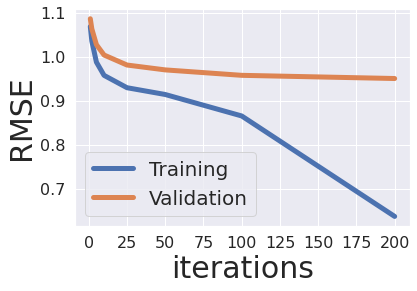

In [27]:
plot_learning_curve(iter_array, MF_sgd)

It is better than before in terms of performance but a lot longer in terms of execution. It might be due to the inclusion of the bias terms. Let us assess the test vs validation error.

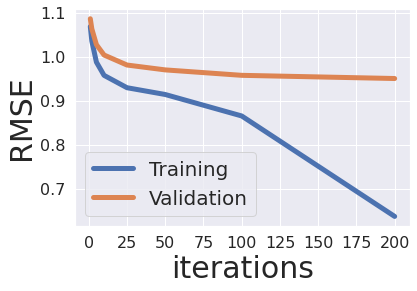

In [30]:
MF_sgd.calculate_learning_curve(iter_array, test, learning_rate=0.001, training=False)

plot_learning_curve(iter_array, MF_sgd)

Test behavior is consistent with the validation error

Let us optimize the SGD model by fine tuning first its learning rate hyperparameters

In [29]:
%% time
iter_array = [1, 2, 5, 10, 25, 50, 100, 200]
learning_rates = [1e-5, 1e-4, 1e-3, 1e-2]

best_params = {}
best_params['learning_rate'] = None
best_params['n_iter'] = 0
best_params['train_rmse'] = np.inf
best_params['val_rmse'] = np.inf
best_params['model'] = None


for rate in learning_rates:
    print(f'Rate: {rate}')
    MF_sgdOpt = MF(train, n_factors=40, learning='sgd')
    MF_sgdOpt.calculate_learning_curve(iter_array, validation, learning_rate=rate)
    min_idx = np.argmin(MF_sgdOpt.val_rmse)
    if MF_sgdOpt.val_rmse[min_idx] < best_params['val_rmse']:
        best_params['n_iter'] = iter_array[min_idx]
        best_params['learning_rate'] = rate
        best_params['train_rmse'] = MF_sgdOpt.train_rmse[min_idx]
        best_params['val_rmse'] = MF_sgdOpt.val_rmse[min_idx]
        best_params['model'] = MF_sgdOpt
        print('New optimal hyperparameters')
        print(pd.Series(best_params))

UsageError: Cell magic `%%` not found.


The best validation rmse is at a learning rate of 0.001.

In [48]:
%%time
iter_array = [1, 2, 5, 10, 25, 50, 100, 200]
latent_factors = [5, 10, 20, 40, 80]
regularizations = [0.001, 0.01, 0.1, 1.]
regularizations.sort()

best_params = {}
best_params['n_factors'] = latent_factors[0]
best_params['reg'] = regularizations[0]
best_params['n_iter'] = 0
best_params['train_rmse'] = np.inf
best_params['val_rmse'] = np.inf
best_params['model'] = None

for fact in latent_factors:
    print(f'Factors: {fact}')
    for reg in regularizations:
        print(f'Regularization: {reg}')
        MF_sgdOpt2 = MF(train, n_factors=fact, learning='sgd',\
                            user_fact_reg=reg, item_fact_reg=reg, \
                            user_bias_reg=reg, item_bias_reg=reg)
        MF_sgdOpt2.calculate_learning_curve(iter_array, validation, learning_rate=0.001)
        min_idx = np.argmin(MF_sgdOpt2.val_rmse)
        if MF_sgdOpt2.val_rmse[min_idx] < best_params['val_rmse']:
            best_params['n_factors'] = fact
            best_params['reg'] = reg
            best_params['n_iter'] = iter_array[min_idx]
            best_params['train_rmse'] = MF_sgdOpt2.train_rmse[min_idx]
            best_params['val_rmse'] = MF_sgdOpt2.val_rmse[min_idx]
            best_params['model'] = MF_sgdOpt2
            print('New optimal hyperparameters')
            print(pd.Series(best_params))

Factors: 5
Regularization: 0.001
New optimal hyperparameters
n_factors                                          5
reg                                            0.001
n_iter                                           100
train_rmse                                  0.872719
val_rmse                                    0.992934
model         <__main__.MF object at 0x7fde96caea60>
dtype: object
Regularization: 0.01
New optimal hyperparameters
n_factors                                          5
reg                                             0.01
n_iter                                           200
train_rmse                                  0.814386
val_rmse                                    0.977393
model         <__main__.MF object at 0x7fde96c6caf0>
dtype: object
Regularization: 0.1
New optimal hyperparameters
n_factors                                          5
reg                                              0.1
n_iter                                           200
train_rmse         

KeyboardInterrupt: 

Thus with a learning rate of 0.001, the optimal hyperparameters are:
n_factors                                         40
reg                                             0.01
n_iter                                           200

with a val rmse at 0.959299

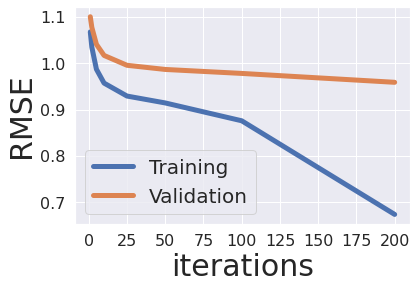

In [49]:
plot_learning_curve(iter_array, best_params['model'])

In [51]:

print(f'Best regularization: {best_params["reg"]}')
print(f'Best latent factors: {best_params["n_factors"]}')
print(f'Best iterations: {best_params["n_iter"]}')

Best regularization: 0.01
Best latent factors: 40
Best iterations: 200


It seems we could increase the iteration count to get an even better performance on the validation set